# Tutorial of single-cell imputation and denoising 

This package provides functions for the evaluation of imputation and denoising methods on single-cell
metabolomics and lipidomics data. This process includes the following steps:

1. Data preprocessing: filtering, normalization, and variance stabilization
2. Imputation and denoising: application of different methods
3. Evaluation: comparison of imputed/denoised data with the original data using different metrics

The package also provides functions for the visualization of the results.


In [1]:
import os
import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import sys

sys.path.append("/home/mklein/sc_imputation_denoising")
import sc_imputation_denoising

from sc_imputation_denoising.imputation.constants import const

In [2]:
# load anndata object
data_path = os.path.join(
    const.IN_DATA_DIR,
    "Mx_Seahorse.h5ad",
)
adata = ad.read_h5ad(data_path)

# sub
adata.obs[const.CONDITION_COL] = adata.obs["dataset_0"]
adata = adata[adata.obs[const.CONDITION_COL].isin(["Stim", "NStim"]), :]


Removed 642 out of 1004 ions
Filtered 71 out of 7462 cells
Different effect of filtering on different subsets (condition):
           difference_cells relative_reduction
condition                                     
NStim                     5              0.15%
Stim                     66              1.59%
Reduced dropout rate from 74.62% to 32.33%.


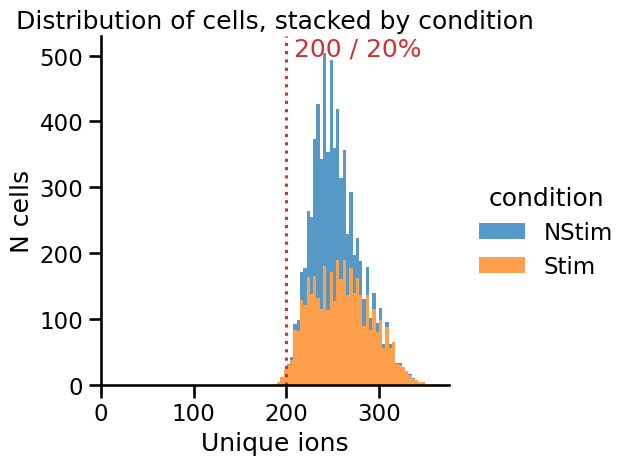

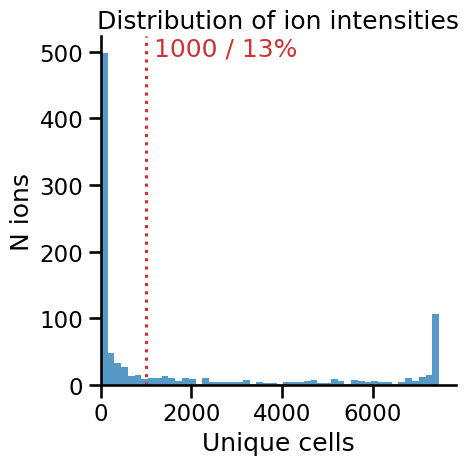

In [38]:
from sc_imputation_denoising.imputation.filtering import plot_filtering_qc

# Systematic filtering: this function plots the distribution of unique cells and ions in the dataset
# and filters by the supplied number of ions and cells. The function returns the filtered anndata object
# and the plot objects for further customization.
adata_res, i, o = plot_filtering_qc(
    adata, n_ions=200, n_cells=1000, cell_hue_variable="condition",
)

Removed 678 out of 1004 ions
Filtered 5623 out of 7462 cells
Different effect of filtering on different subsets (condition):
           difference_cells relative_reduction
condition                                     
NStim                  2889             87.39%
Stim                   2734             65.78%
Reduced dropout rate from 74.62% to 18.56%.


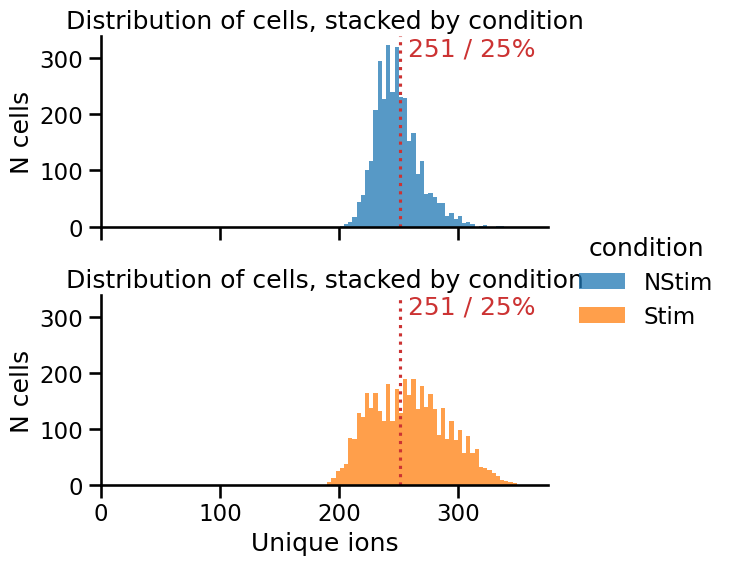

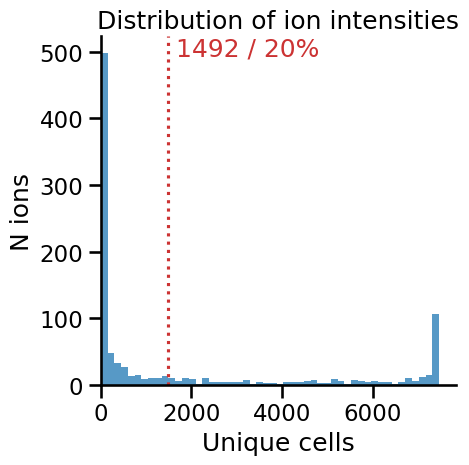

In [36]:
from sc_imputation_denoising.imputation.filtering import plot_filtering_qc

# Filtering can also be performed by a fraction of the total number of cells and ions. In addition,
# keyword arguments can be supplied to customize the histograms.
adata_res2, i, o = plot_filtering_qc(
    adata,
    cell_hue_variable="condition",
    n_cells=0.2,
    n_ions=0.25,
    row="condition",
    aspect=2,
    height=3,
)

In [39]:
# General preprocessing: removing completely empty cells and ions, normalization,
# variance stabilization

# simulation of dropouts is performed in parallel on raw data to enable the application of imputation
# methods to the raw data directly. However, this requires that the anndata object has a raw attribute
adata_res.raw = adata_res
sc.pp.normalize_total(adata_res, target_sum=1e4)
sc.pp.log1p(adata_res)

In [5]:
from sc_imputation_denoising.evaluation.evaluation_workflow import evaluation_workflow
# This function initializes the evaluation workflow. It takes the anndata object, the column name
# of the condition variable, and if applicable column names of the batch and sample columns in 
# adata.obs. The function returns an object of the evaluation_workflow class.
wflow = evaluation_workflow(adata=adata_res, condition_col="condition")

In [43]:
# This function enables the simulation of dropouts. It takes either a list of dropout rates or
# a number of levels to simulate dropouts at in logarrithmic space. The method argument specifies
# the dropout mechanism.
wflow.simulate_dropouts(n_logspace=2, method="mnar", value_importance=2)

Generated 3 datasets with increasing dropout rates: 0.32331579919134146, 0.47, 0.69
simulating dropout rates [0.32331579919134146, 0.47, 0.69] with method mnar
supplied adata has raw attribute. Simulating dropouts here aswell. You can preven this by setting argument simulate_raw=False
supplied adata has raw attribute. Simulating dropouts here aswell. You can preven this by setting argument simulate_raw=False
supplied adata has raw attribute. Simulating dropouts here aswell. You can preven this by setting argument simulate_raw=False


In [8]:
# When no dropouts should be simulated on top of the raw data, the function can be called without
# arguments.
# wflow.simulate_dropouts()

In [44]:
from sklearn.impute import KNNImputer
# To apply different imputation methods, the dataset_dict attribute of the evaluation_workflow
# object can be used. It is a dictionary of anndata objects with the corresponding dropout rate as
# keys. The following example applies a simple kNN imputer to the raw data.
for k, adata in wflow.dataset_dict.items():
    # simple kNN imputer
    print(f"dropout rate: {k}")
    # we choose to vary the number of neighbors to assess the performance of different configurations
    for nn in [3, 5]:
        print(f"number of nearest neighbors: {nn}")
        imputer = KNNImputer(
            missing_values=0, # missing values are encoded as 0
            n_neighbors=nn,
            weights="uniform",
            keep_empty_features=True, # ensures that the absolute size of the data matrix is not changed
        )
        # the imputer is both fitted and applied to the original dataset which is automatically 
        # available from the 'ctrl' layer of the anndata object. The result of the imputation is
        # stored in a new layer of the anndata object.
        adata.layers[f"knn_{nn}"] = imputer.fit_transform(
            np.array(adata.layers["ctrl"])
        )

dropout rate: 0.32_baseline
number of nearest neighbors: 3
number of nearest neighbors: 5
dropout rate: 0.47
number of nearest neighbors: 3
number of nearest neighbors: 5
dropout rate: 0.69
number of nearest neighbors: 3
number of nearest neighbors: 5


In [46]:
from fancyimpute import IterativeSVD
# This is another example of an imputation method. 

for k, adata in wflow.dataset_dict.items():
    print(f"dropout rate: {k}")
    for rank in [10, 20, 50]:
        print(f"approximation rank: {rank}")

        # this method only recognizes np.nan as missing values and cannot retain columns where all
        # values are missing. Therefore, we first replace all zeros with np.nan and then replace the 
        # zeros in the columns that are completely zero with 0 again.
        array = np.copy(adata.layers["ctrl"])
        only_zero = np.all(array == 0, axis=0)
        array[array == 0] = np.nan
        array[:, only_zero] = 0  # only zero columns are not imputed
        
        # the method is also given a minimum imputation value of 0 to ensure that all values 
        # returned by the imputation are non-negative
        adata.layers[f"fancy_itersvd_{rank}"] = IterativeSVD(
            rank=rank, min_value=0
        ).fit_transform(array)

dropout rate: 0.32_baseline
approximation rank: 10
[IterativeSVD] Iter 1: observed MAE=7.625539
[IterativeSVD] Iter 2: observed MAE=4.252965
[IterativeSVD] Iter 3: observed MAE=3.127315
[IterativeSVD] Iter 4: observed MAE=2.492384
[IterativeSVD] Iter 5: observed MAE=2.197811
[IterativeSVD] Iter 6: observed MAE=2.063237
[IterativeSVD] Iter 7: observed MAE=1.981404
[IterativeSVD] Iter 8: observed MAE=1.927175
[IterativeSVD] Iter 9: observed MAE=1.888782
[IterativeSVD] Iter 10: observed MAE=1.860279
[IterativeSVD] Iter 11: observed MAE=1.838184
[IterativeSVD] Iter 12: observed MAE=1.820487
[IterativeSVD] Iter 13: observed MAE=1.805946
[IterativeSVD] Iter 14: observed MAE=1.793761
[IterativeSVD] Iter 15: observed MAE=1.783360
[IterativeSVD] Iter 16: observed MAE=1.774346
[IterativeSVD] Iter 17: observed MAE=1.766432
[IterativeSVD] Iter 18: observed MAE=1.759394
[IterativeSVD] Iter 19: observed MAE=1.753079
[IterativeSVD] Iter 20: observed MAE=1.747389
[IterativeSVD] Iter 21: observed MAE=1

In [47]:
# the dataset_dict attribute of the evaluation_workflow object shows clearly that different
# imputation methods have been applied to the original data
wflow.dataset_dict

{'0.32_baseline': AnnData object with n_obs × n_vars = 7391 × 362
     obs: 'center_x', 'center_y', 'cell_area', 'cell_sampling_area', 'cell_sampling_ratio', 'cell_nearest_am_distance', 'cell_nearest_cell_distance', 'centroid-0', 'centroid-1', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'local_centroid-0', 'local_centroid-1', 'area', 'filled_area', 'solidity', 'perimeter', 'eccentricity', 'euler_number', 'moments_hu-0', 'moments_hu-1', 'moments_hu-2', 'moments_hu-3', 'moments_hu-4', 'moments_hu-5', 'moments_hu-6', 'moments_central-0-0', 'moments_central-0-1', 'moments_central-0-2', 'moments_central-0-3', 'moments_central-1-0', 'moments_central-1-1', 'moments_central-1-2', 'moments_central-1-3', 'moments_central-2-0', 'moments_central-2-1', 'moments_central-2-2', 'moments_central-2-3', 'moments_central-3-0', 'moments_central-3-1', 'moments_central-3-2', 'moments_central-3-3', 'inertia_tensor_eigvals-0', 'inertia_tensor_eigvals-1', 'major_axis_length', 'minor_axis_length', 'weighted_moments_

In [48]:
# This function starts the evaluation of the imputation methods. It precalculates the PCA and UMAP
# Embeddings of the imputed data and stores all individual imputed matrices in a list to enable 
# an easy access to the results. 
wflow.init_analysis(precalc_umap=True, n_jobs=10)

Precalculating PCs and UMAPs


  0%|          | 0/18 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


100%|██████████| 18/18 [00:00<00:00, 53.60it/s]
2023-07-09 17:24:44.024020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 17:24:44.230697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 17:24:44.681574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performan

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done   2 out of  18 | elapsed:  5.5min remaining: 43.9min
[Parallel(n_jobs=10)]: Done   3 out of  18 | elapsed:  5.5min remaining: 27.7min
[Parallel(n_jobs=10)]: Done   4 out of  18 | elapsed:  5.8min remaining: 20.2min
[Parallel(n_jobs=10)]: Done   5 out of  18 | elapsed:  6.0min remaining: 15.5min
[Parallel(n_jobs=10)]: Done   6 out of  18 | elapsed:  6.1min remaining: 12.1min
[Parallel(n_jobs=10)]: Done   7 out of  18 | elapsed:  6.1min remaining:  9.5min
[Parallel(n_jobs=10)]: Done   8 out of  18 | elapsed:  6.2min remaining:  7.7min
[Parallel(n_jobs=10)]: Done   9 out of  18 | elapsed:  6.2min remaining:  6.2min
[Parallel(n_jobs=10)]: Done  10 out of  18 | elapsed:  6.2min remaining:  5.0min
[Parallel(n_jobs=10)]: Done  11 out of  18 | elapsed:  6.2min remaining:  4.0min
[Parallel(n_jobs=10)]: Done  12 out of  18 | elapsed:  6.4min remaining:  3.2min
[Parallel(n_jobs=10)]: Done  13 out of  18 | el

In [49]:
# This function performs the evaluation of the imputation methods. It returns the different metrics
# for each imputation method and dropout rate in a pandas dataframe.
metric_df = wflow.analyse_imputation()
metric_df

100%|██████████| 18/18 [00:00<00:00, 57.73it/s]


kMeans_ari  Silhouette_Score  \
ctrl_0.32_baseline                0.069750          0.259060   
knn_3_0.32_baseline               0.053830          0.171550   
knn_5_0.32_baseline               0.054465          0.172386   
fancy_itersvd_10_0.32_baseline    0.035321          0.120932   
fancy_itersvd_20_0.32_baseline    0.041570          0.121182   
fancy_itersvd_50_0.32_baseline    0.040827          0.267976   
ctrl_0.47                         0.025050          0.159734   
knn_3_0.47                        0.035337          0.132519   
knn_5_0.47                        0.035754          0.134192   
fancy_itersvd_10_0.47             0.042002          0.254946   
fancy_itersvd_20_0.47             0.042310          0.267644   
fancy_itersvd_50_0.47             0.054407          0.268408   
ctrl_0.69                         0.005625          0.053539   
knn_3_0.69                        0.019931          0.086087   
knn_5_0.69                        0.019246          0.086674   
fancy_itersvd_10_0.69             0.031610          0.208599   
fancy_itersvd_20_0.69             0.045048          0.219430   
fancy_itersvd_50_0.69             0.061613          0.233420   

                                Davies_Bouldin_Score  Calinski_Harabasz_Score  \
ctrl_0.32_baseline                         -5.828553               211.656534   
knn_3_0.32_baseline                        -4.137964               333.533529   
knn_5_0.32_baseline                        -4.123797               334.734842   
fancy_itersvd_10_0.32_baseline             -3.389611               548.299013   
fancy_itersvd_20_0.32_baseline             -3.512483               525.043546   
fancy_itersvd_50_0.32_baseline             -3.706799               475.512865   
ctrl_0.47                                  -8.483861               101.025479   
knn_3_0.47                                 -4.522249               290.378199   
knn_5_0.47                                 -4.482129               293.996643   
fancy_itersvd_10_0.47                      -3.231023               638.034021   
fancy_itersvd_20_0.47                      -3.615021               523.593443   
fancy_itersvd_50_0.47                      -3.720321               495.470239   
ctrl_0.69                                 -14.393420                35.143542   
knn_3_0.69                                 -5.326491               208.947898   
knn_5_0.69                                 -5.262009               211.132083   
fancy_itersvd_10_0.69                      -3.360654               601.467162   
fancy_itersvd_20_0.69                      -3.902407               458.297084   
fancy_itersvd_50_0.69                      -3.907346               455.812376   

                                MSE_values  MSE_variance  Ion_Correlation  \
ctrl_0.32_baseline               -0.000000     -0.000000              NaN   
knn_3_0.32_baseline            -430.643982 -36336.484375              NaN   
knn_5_0.32_baseline            -430.736908 -36432.695312              NaN   
fancy_itersvd_10_0.32_baseline -353.042450 -33127.757812              NaN   
fancy_itersvd_20_0.32_baseline -326.124664 -31871.388672              NaN   
fancy_itersvd_50_0.32_baseline -306.081329 -30604.259766              NaN   
ctrl_0.47                      -195.363571 -21249.435547              NaN   
knn_3_0.47                     -438.892731 -38081.808594              NaN   
knn_5_0.47                     -438.775330 -38235.144531              NaN   
fancy_itersvd_10_0.47          -333.787140 -33514.214844              NaN   
fancy_itersvd_20_0.47          -297.379089 -31716.177734              NaN   
fancy_itersvd_50_0.47          -251.810364 -29489.179688              NaN   
ctrl_0.69                      -567.251831 -91834.218750              NaN   
knn_3_0.69                     -448.305939 -39298.468750              NaN   
knn_5_0.69                     -448.202209 -39511.871094              NaN   
fancy_itersvd_10_0.69          -284.628723 

In [50]:
# To model the case where no dropouts were simulated, I quickly remove the simulated sparsity levels
# from the metric_df.
metric_df_baseline = metric_df.loc[metric_df["dropout_rate"] == wflow.baseline_key,~metric_df.columns.isin(["dropout_rate"])]
metric_df_baseline

kMeans_ari  Silhouette_Score  \
ctrl_0.32_baseline                0.069750          0.259060   
knn_3_0.32_baseline               0.053830          0.171550   
knn_5_0.32_baseline               0.054465          0.172386   
fancy_itersvd_10_0.32_baseline    0.035321          0.120932   
fancy_itersvd_20_0.32_baseline    0.041570          0.121182   
fancy_itersvd_50_0.32_baseline    0.040827          0.267976   

                                Davies_Bouldin_Score  Calinski_Harabasz_Score  \
ctrl_0.32_baseline                         -5.828553               211.656534   
knn_3_0.32_baseline                        -4.137964               333.533529   
knn_5_0.32_baseline                        -4.123797               334.734842   
fancy_itersvd_10_0.32_baseline             -3.389611               548.299013   
fancy_itersvd_20_0.32_baseline             -3.512483               525.043546   
fancy_itersvd_50_0.32_baseline             -3.706799               475.512865   

                                MSE_values  MSE_variance  Ion_Correlation  \
ctrl_0.32_baseline               -0.000000     -0.000000              NaN   
knn_3_0.32_baseline            -430.643982 -36336.484375              NaN   
knn_5_0.32_baseline            -430.736908 -36432.695312              NaN   
fancy_itersvd_10_0.32_baseline -353.042450 -33127.757812              NaN   
fancy_itersvd_20_0.32_baseline -326.124664 -31871.388672              NaN   
fancy_itersvd_50_0.32_baseline -306.081329 -30604.259766              NaN   

                                Cell_Correlation  Ion_Correlation_Deviation  \
ctrl_0.32_baseline                      0.588921                  -0.000000   
knn_3_0.32_baseline                     0.816180                  -0.512794   
knn_5_0.32_baseline                     0.819588                  -0.516983   
fancy_itersvd_10_0.32_baseline          0.736567                  -0.347014   
fancy_itersvd_20_0.32_baseline          0.713344                  -0.293821   
fancy_itersvd_50_0.32_baseline          0.704267                  -0.250146   

                                      imputation  
ctrl_0.32_baseline                          ctrl  
knn_3_0.32_baseline                        knn_3  
knn_5_0.32_baseline                        knn_5  
fancy_itersvd_10_0.32_baseline  fancy_itersvd_10  
fancy_itersvd_20_0.32_baseline  fancy_itersvd_20  
fancy_itersvd_50_0.32_baseline  fancy_itersvd_50

In [51]:
from sc_imputation_denoising.evaluation.evaluation_plots import get_combined_score_df
# To enable easy plotting of the results, the different metrics are combined into two scores:
# one for cluster separation and one for information recovery.
results_df = get_combined_score_df(metric_df)
results_df_baseline = get_combined_score_df(metric_df_baseline)

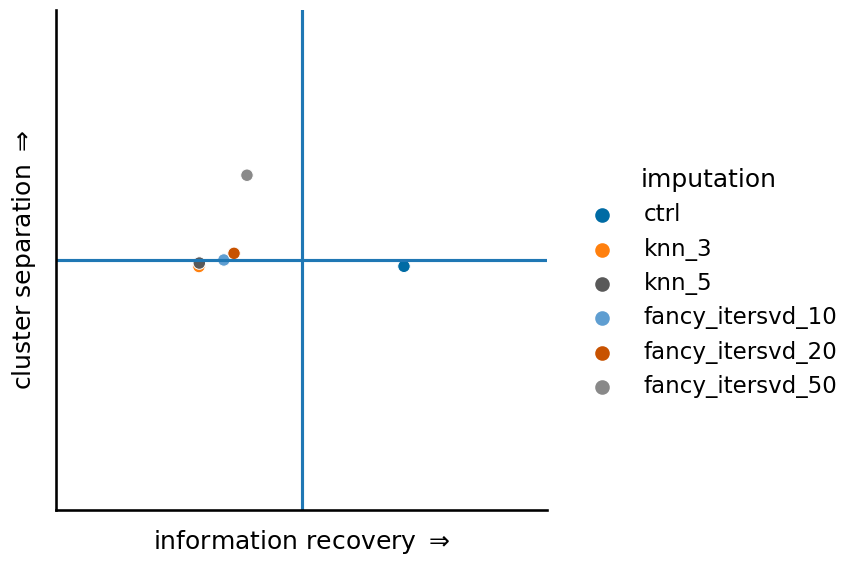

In [69]:
from importlib import reload
reload(sc_imputation_denoising.evaluation.evaluation_plots)
from sc_imputation_denoising.evaluation.evaluation_plots import (
    plot_performance_matrix,
    plot_umap_overview,
)
# these results can be easily plotted using the plot_performance_matrix function, again supplying
# additional keyword arguments to customize the plot.

plot_performance_matrix(results_df_baseline, imp_variable='imputation', height=6)

In [56]:
# To make the plotted results clearer, the imputation methods are grouped by their general concept.
# The control/ctrl data (no imputation) is not assigned to a group (assigned np.nan as a group name).
# this should be done manually as it depends on the applied methods and their naming.
results_df["group"] = [
    "_".join(i.split("_")[:-1]) if i != "ctrl" else np.nan
    for i in results_df["imputation"]
]
results_df_baseline["group"] = [
    "_".join(i.split("_")[:-1]) if i != "ctrl" else np.nan
    for i in results_df_baseline["imputation"]
]
results_df[["imputation", "group"]]

imputation          group
ctrl_0.32_baseline                          ctrl            NaN
knn_3_0.32_baseline                        knn_3            knn
knn_5_0.32_baseline                        knn_5            knn
fancy_itersvd_10_0.32_baseline  fancy_itersvd_10  fancy_itersvd
fancy_itersvd_20_0.32_baseline  fancy_itersvd_20  fancy_itersvd
fancy_itersvd_50_0.32_baseline  fancy_itersvd_50  fancy_itersvd
ctrl_0.47                                   ctrl            NaN
knn_3_0.47                                 knn_3            knn
knn_5_0.47                                 knn_5            knn
fancy_itersvd_10_0.47           fancy_itersvd_10  fancy_itersvd
fancy_itersvd_20_0.47           fancy_itersvd_20  fancy_itersvd
fancy_itersvd_50_0.47           fancy_itersvd_50  fancy_itersvd
ctrl_0.69                                   ctrl            NaN
knn_3_0.69                                 knn_3            knn
knn_5_0.69                                 knn_5            knn
fancy_itersvd_10_0.69           fancy_itersvd_10  fancy_itersvd
fancy_itersvd_20_0.69           fancy_itersvd_20  fancy_itersvd
fancy_itersvd_50_0.69           fancy_itersvd_50  fancy_itersvd

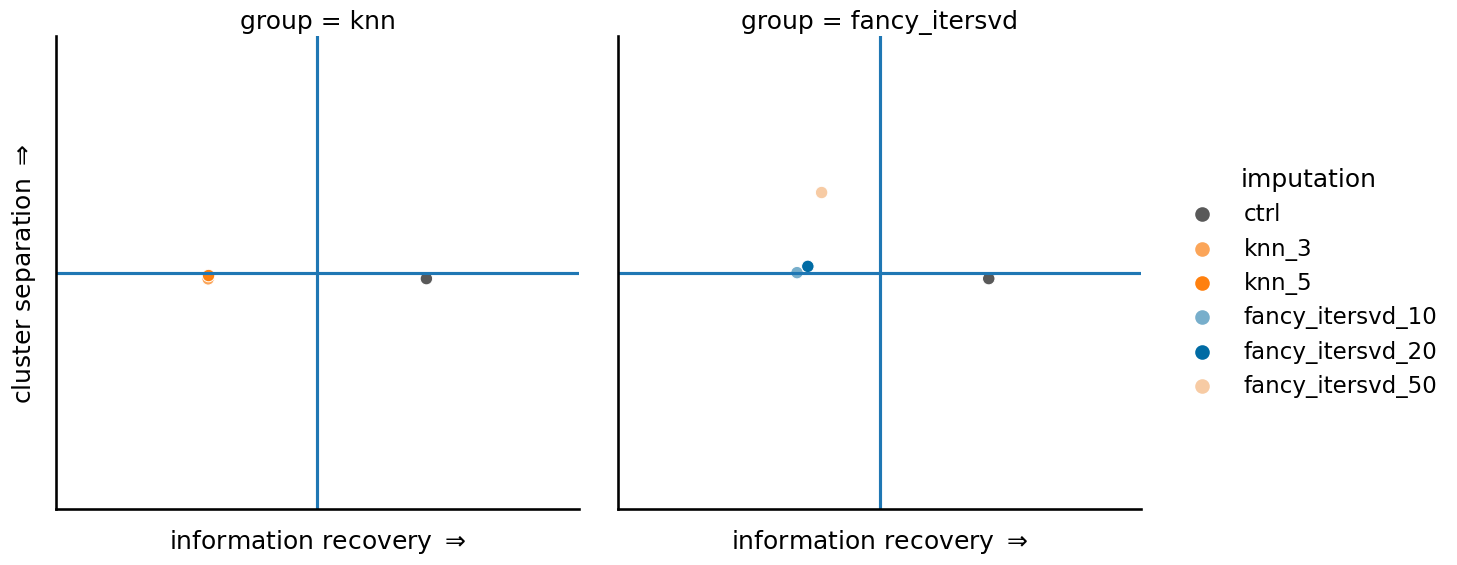

In [57]:
# this grouping column is then supplied to the plot_performance_matrix function to plot the results
# in a grouped manner, compared to the ctrl.
plot_performance_matrix(
    results_df_baseline, height=6, col_variable="group"
)

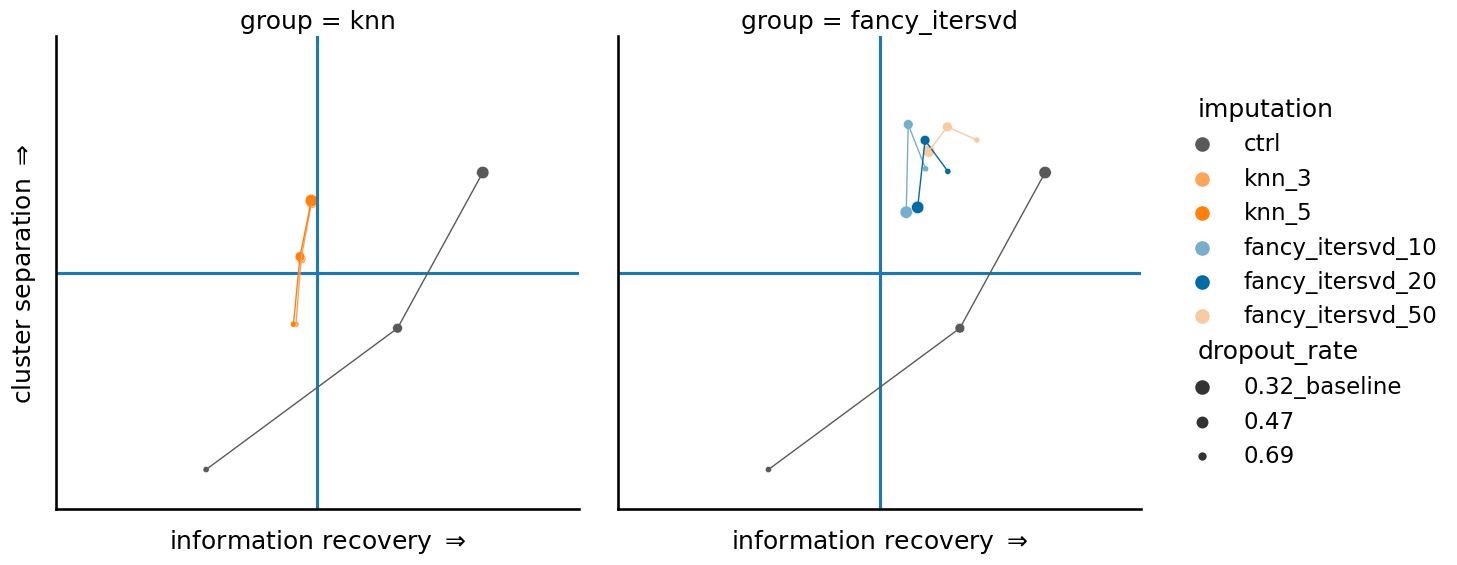

In [58]:
# this plot also accepts different dropout rates of a simulation. In this case, the results of one
# imputation method are connected by a line of the same color.
plot_performance_matrix(results_df, imp_variable='imputation', size_variable="dropout_rate", col_variable='group', height=6)

In [59]:
import scanpy as sc
# also a visual representation can be plotted using the umap coordinates of the data. To enable this, 
# the umap coordinates of all cells given all imputation methods are obtained from the evaluation_workflow

umap_df = wflow.analyse_imputation(function=wflow._analyse_umap)

# To model the case where no dropouts were simulated, I quickly remove the simulated sparsity levels
# from the umap_df.
umap_df_baseline = umap_df.loc[umap_df["dropout_rate"] == wflow.baseline_key,~umap_df.columns.isin(["dropout_rate"])]
umap_df_baseline

100%|██████████| 18/18 [00:01<00:00, 17.48it/s]


condition   C6H8O7-H  C9H13N5O3-H  C4H7NO4+Cl  C5H6O5+Cl   X_umap-0  \
cell_id                                                                        
21316_G1     NStim   0.000000     0.000000    0.000000   0.000000  -5.661685   
21319_G1     NStim   0.000000     0.000000   36.956417  38.840797  -3.403779   
21320_G1     NStim   0.000000     0.000000   33.374954  33.300499  -1.896492   
21321_G1     NStim   0.000000     0.000000   33.648937  34.786060  -1.957146   
21322_G1     NStim   0.000000     0.000000   34.268127   0.000000  -3.561183   
...            ...        ...          ...         ...        ...        ...   
30195_J2      Stim  14.003380    29.391808   33.187496  33.259888   8.644104   
30197_J2      Stim  22.681463    30.065063   31.532513  34.323219   6.831518   
30198_J2      Stim  22.729828    25.485142   35.077484  38.119797   9.508621   
30199_J2      Stim  23.097267    34.413631   35.937981  36.346634   5.610033   
30204_J2      Stim   6.441899    15.603127   31.515087  33.514656  10.530699   

          X_umap-1        imputation  
cell_id                               
21316_G1  4.439242              ctrl  
21319_G1  4.236477              ctrl  
21320_G1  3.133022              ctrl  
21321_G1  4.105014              ctrl  
21322_G1  4.231655              ctrl  
...            ...               ...  
30195_J2 -0.149716  fancy_itersvd_50  
30197_J2 -0.338899  fancy_itersvd_50  
30198_J2  0.151248  fancy_itersvd_50  
30199_J2  2.571965  fancy_itersvd_50  
30204_J2  0.632190  fancy_itersvd_50  

[44346 rows x 8 columns]

No 'dropout_rate' column found, assuming all data matrices have the same dropout rate. Facetting only by imputation.


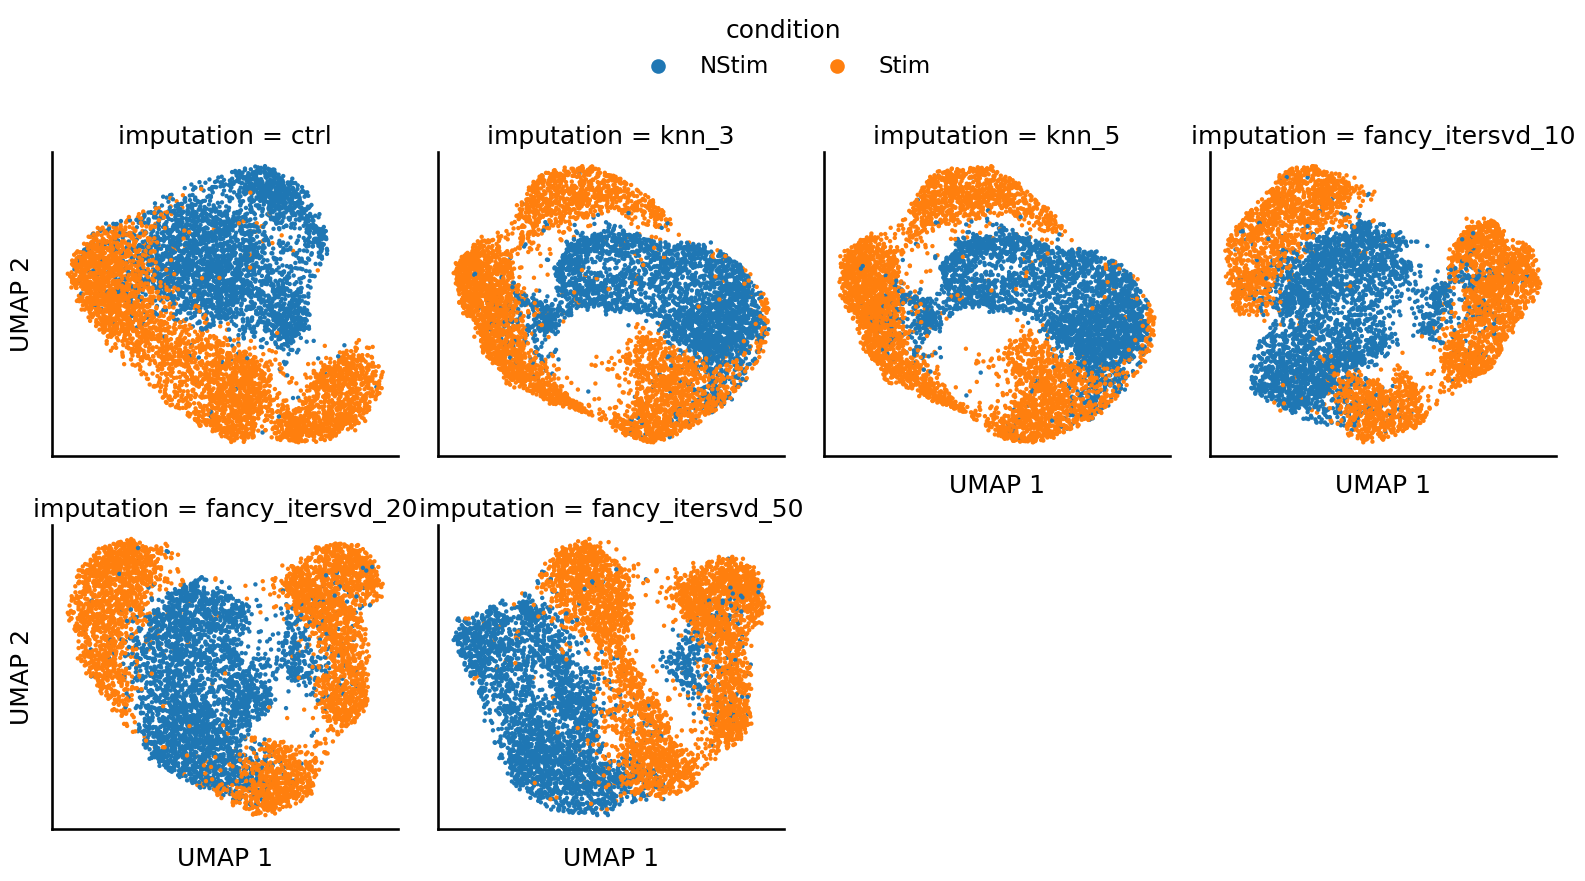

In [73]:
# These coordinates can then be plotted using the plot_umap_overview function. 
reload(sc_imputation_denoising.evaluation.evaluation_plots)
from sc_imputation_denoising.evaluation.evaluation_plots import plot_umap_overview
plot_umap_overview(umap_df_baseline, col_wrap=4)

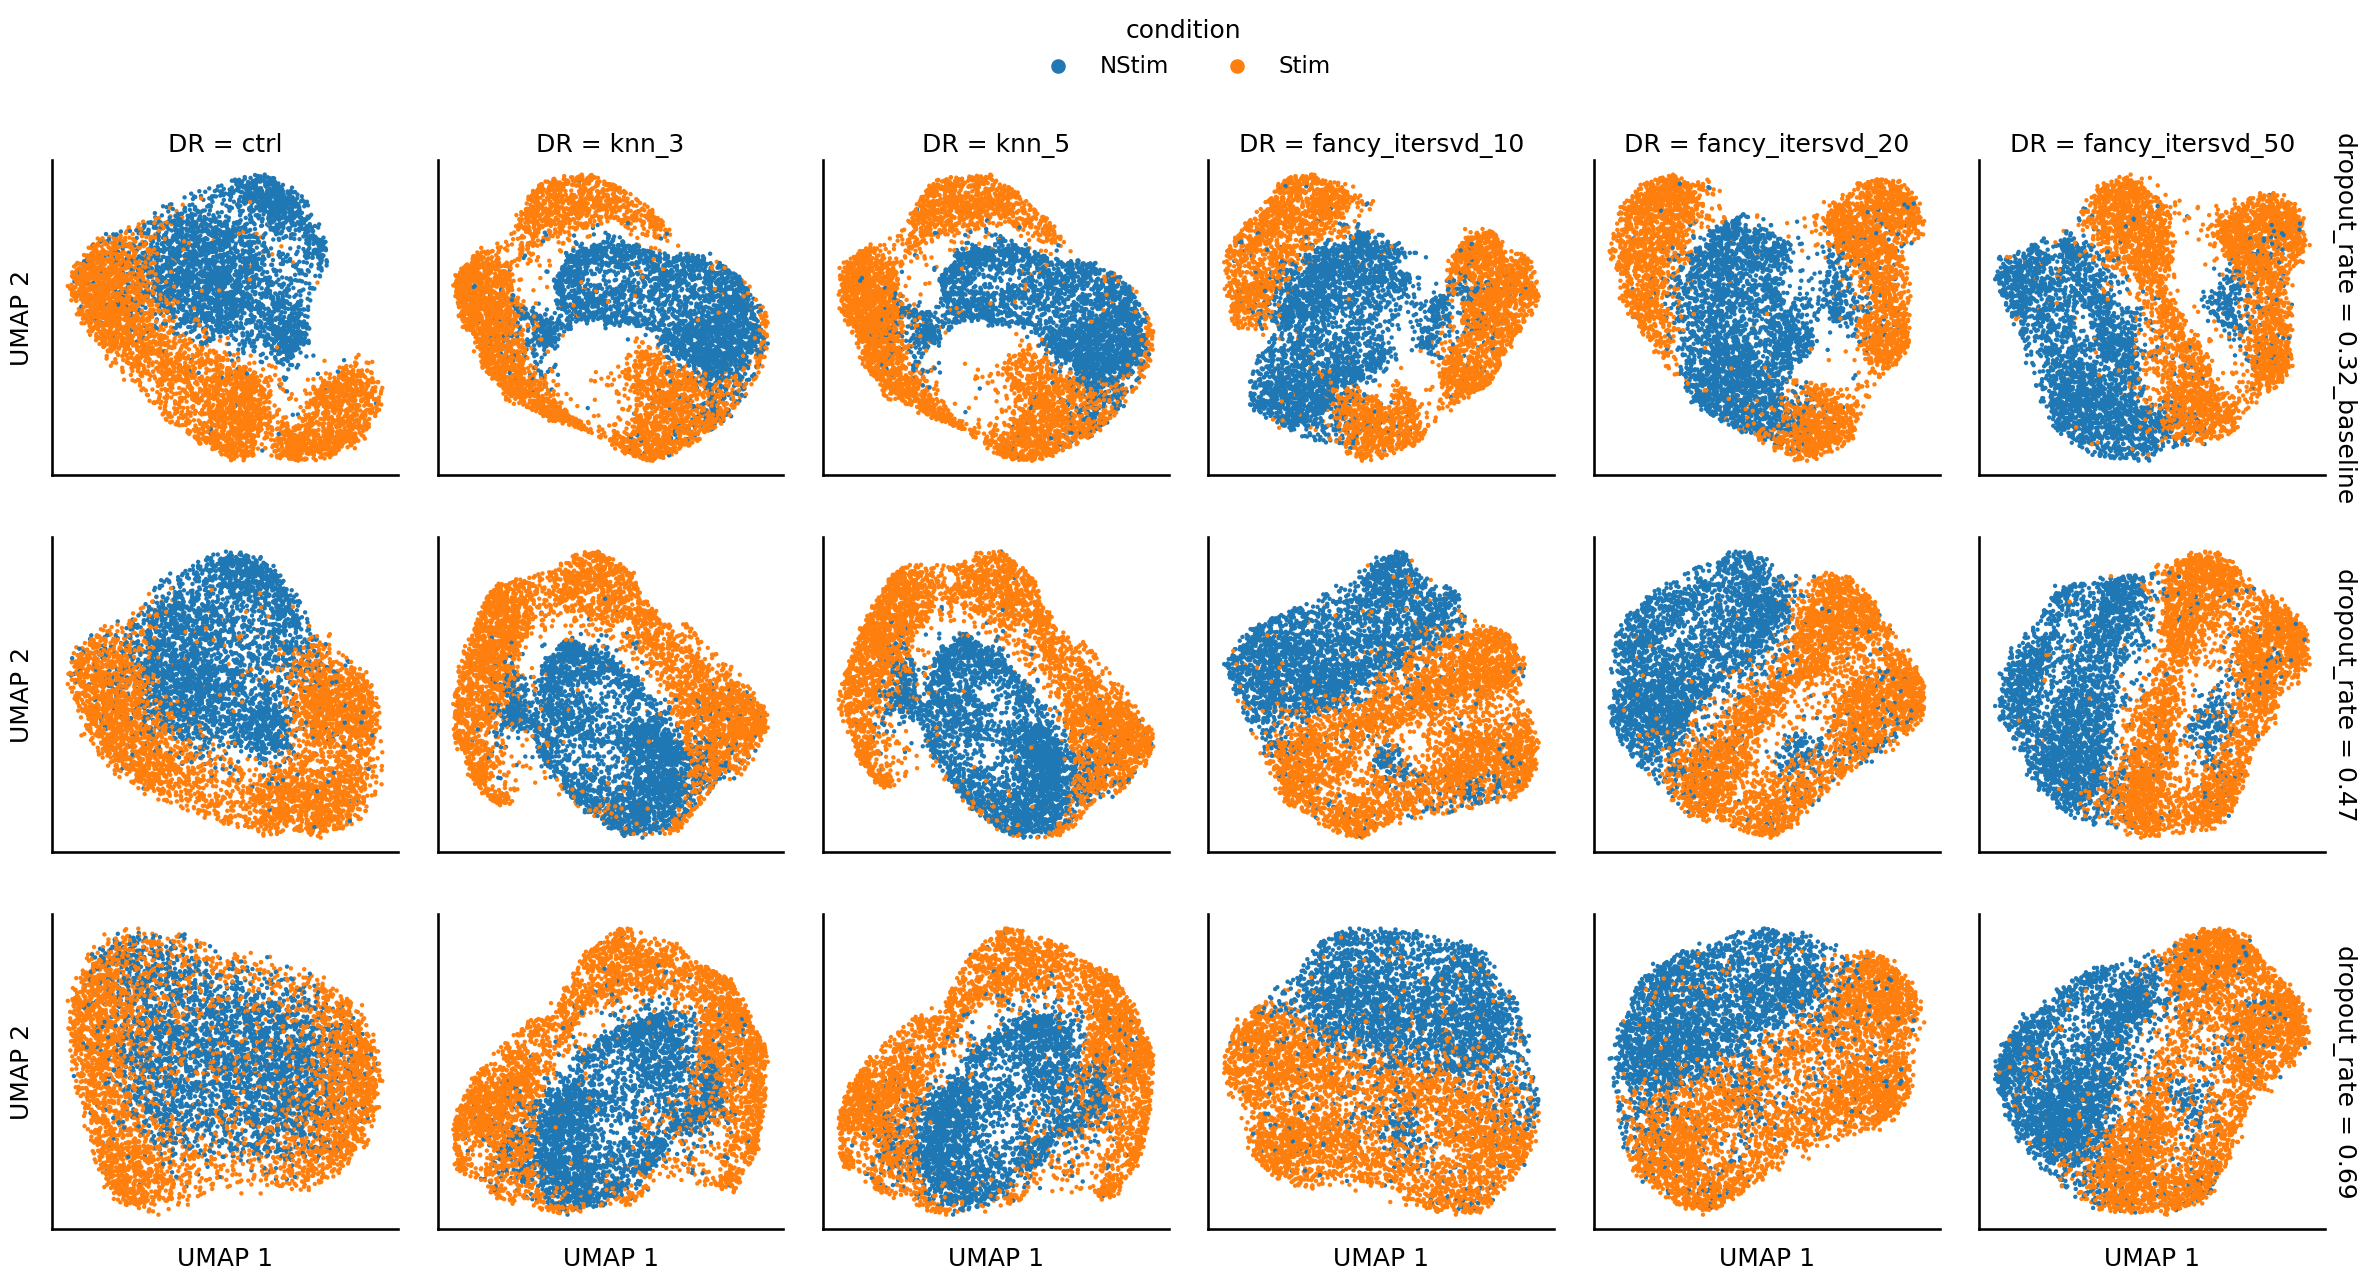

In [62]:
# If multiple dropout rates were simulated, the plot_umap_overview function can also plot the results
# using both columns and rows to represent the different dropout rates and imputation methods.
plot_umap_overview(umap_df)

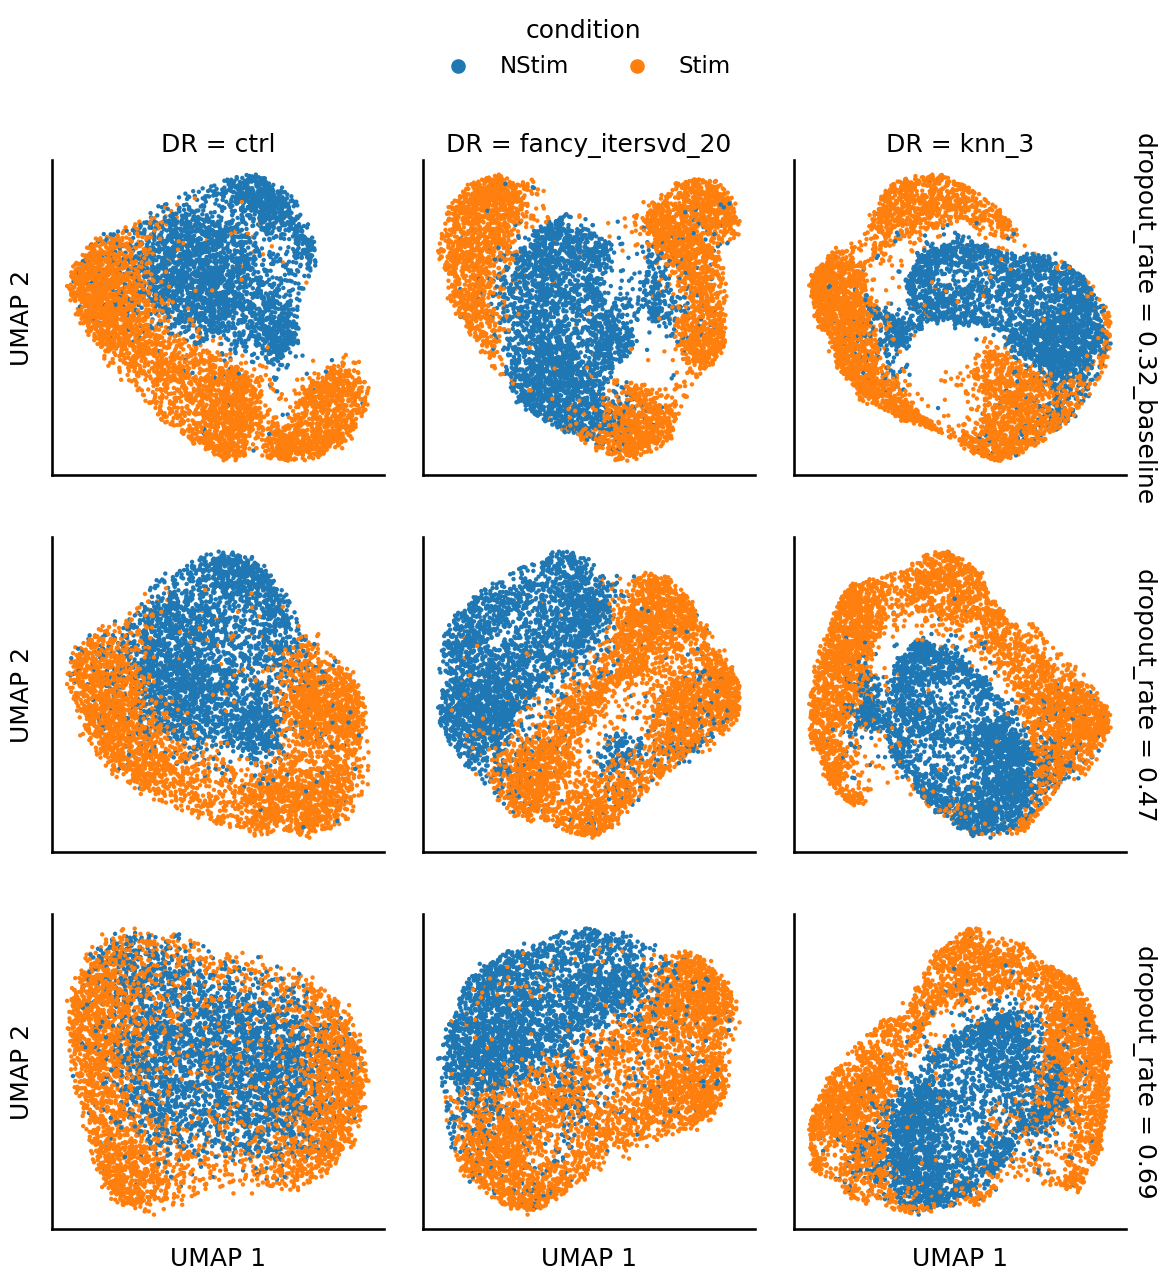

In [ ]:
# Again, additional keyword arguments can be supplied to customize the plot.
plot_umap_overview(umap_df, col_order=["ctrl", "fancy_itersvd_20", "knn_3"])

'/home/mklein'

In [8]:
# an evaluation_workflow object can be saved to pickle and loaded again
# wflow.save_to_pickle("wflow.pkl")

wflow = evaluation_workflow.get_from_pickle("/home/mklein/sc_imputation_denoising/wflow.pkl")

The metrics from this work can also be used independently from the workflow:

In [10]:
from sc_imputation_denoising.evaluation.evaluation_metrics import (
    metrics_all
)

adata_raw = wflow.dataset_dict[wflow.baseline_key].copy()
adata_imputed = adata_raw.copy()
adata_raw.X = adata_raw.layers["ctrl"]
adata_imputed.X = adata_imputed.layers["knn_5"]

metrics_all(
    adata=adata_imputed, 
    adata_ctrl=adata_raw, 
    condition_key="condition",
)


ARI...
Silhouette...


2023-07-11 06:35:18.197589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Davies...
Calinski...
MSE values...
MSE variance...
Ion correlation...
Cell correlation...
Ion correlation deviation...


{'kMeans_ari': 0.05446486338887015,
 'Silhouette_Score': 0.17114579677581787,
 'Davies_Bouldin_Score': -4.123797356922979,
 'Calinski_Harabasz_Score': 334.73484157325845,
 'MSE_values': -430.7369079589844,
 'MSE_variance': -36432.6953125,
 'Ion_Correlation': 0.5430047541616035,
 'Cell_Correlation': 0.8195878253841705,
 'Ion_Correlation_Deviation': -0.516983108400731}